<a href="https://colab.research.google.com/github/mobarakol/AI_Medical_Imaging/blob/main/Practical_GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Brain Tumor Dataset<br>
source: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset<br>
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']<br>
number of training MRIs slices = 5712 <br>
number of testing MRIs slices = 1311 <br>

Download the dataset:

In [ ]:
import gdown

url = 'https://drive.google.com/uc?id=1Oms9X0Vpid_kN8jiSgz-3MhRA5BcmivE'
gdown.download(url,'braintumor.zip',quiet=True)
!unzip -q braintumor.zip -d braintumor

Download my trained weights:

In [ ]:
import gdown

!mkdir myweights

#ResNet34
url = 'https://drive.google.com/uc?id=19GYVgCz9wjO4wdCmFWhUw9_Uylzylfqe'
gdown.download(url,'myweights/best_model.pth.tar',quiet=True)

#DesnseNet121
url = 'https://drive.google.com/uc?id=1RQHQiF9LrRKbIUSaCOZd8-9paio6DFZ8'
gdown.download(url,'myweights/best_model_densenet8.pth.tar',quiet=True)

#ViT
url = 'https://drive.google.com/uc?id=1yYBUwjxmrjQevBPleZAQeEyHR-Pq5wWB'
gdown.download(url,'myweights/best_model_vit.pth.tar',quiet=True)

'myweights/best_model_densenet8.pth.tar'

Sample Data:

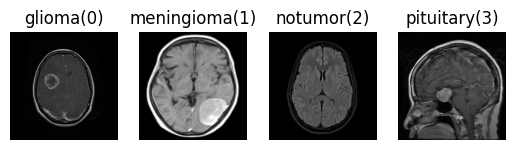

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])
my_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
    ])

class_names = ['glioma(0)', 'meningioma(1)', 'notumor(2)', 'pituitary(3)']

newsize = (224, 224)
img_glioma = Image.open('/content/braintumor/Testing/glioma/Te-gl_0014.jpg').resize(newsize)
img_meningioma = Image.open('/content/braintumor/Testing/meningioma/Te-me_0017.jpg').resize(newsize)
img_healthy = Image.open('/content/braintumor/Testing/notumor/Te-noTr_0002.jpg').resize(newsize)
img_pituitary = Image.open('/content/braintumor/Testing/pituitary/Te-piTr_0008.jpg').resize(newsize)
plt.subplot(1,4,1), plt.axis('OFF'), plt.title(class_names[0]), plt.imshow(img_glioma)
plt.subplot(1,4,2), plt.axis('OFF'),plt.title(class_names[1]), plt.imshow(img_meningioma)
plt.subplot(1,4,3), plt.axis('OFF'),plt.title(class_names[2]), plt.imshow(img_healthy)
plt.subplot(1,4,4), plt.axis('OFF'),plt.title(class_names[3]), plt.imshow(img_pituitary);

Generate GradCAM

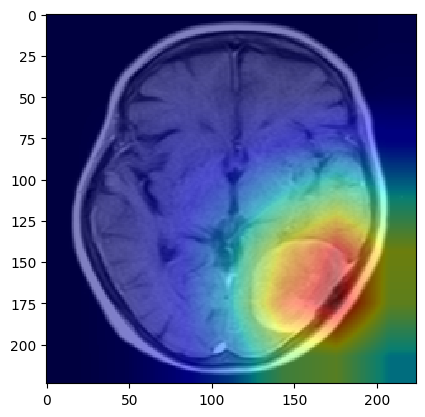

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import cv2
import matplotlib.cm as cm
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()

        # get the pretrained VGG19 network
        self.model = models.resnet34()
        self.model.fc = nn.Linear(self.model.fc.in_features, 4)
        self.model.to(device)
        self.model.load_state_dict(torch.load('myweights/best_model.pth.tar'))

        # isolate the feature blocks
        self.features = nn.Sequential(self.model.conv1,
                                      self.model.bn1,
                                      nn.ReLU(),
                                      nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
                                      self.model.layer1,
                                      self.model.layer2,
                                      self.model.layer3,
                                      self.model.layer4)

        # average pooling layer
        self.avgpool = self.model.avgpool

        # classifier
        self.classifier = self.model.fc

        # gradient placeholder
        self.gradient = None


    # hook for the gradients
    def activations_hook(self, grad):
        self.gradient = grad

    def get_gradient(self):
        return self.gradient

    def get_activations(self, x):
        return self.features(x)

    def forward(self, x):

        # extract the features
        x = self.features(x)

        # register the hook
        h = x.register_hook(self.activations_hook)

        # complete the forward pass
        x = self.avgpool(x)
        x = x.view((1, -1))
        x = self.classifier(x)

        return x

# init the resnet
resnet = ResNet()
resnet.eval()
img = my_transform(img_meningioma).unsqueeze(0).to(device)
logits = resnet(img)
pred = logits.argmax(dim=1).item()

# get the gradient of the output with respect to the parameters of the model
logits[:, pred].backward()

# pull the gradients out of the model
gradients = resnet.get_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = resnet.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]

# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap.cpu().numpy(), 0)

# normalize the heatmap
heatmap /= np.max(heatmap)

img_np = np.array(img_meningioma)
heatmap = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))

plt.imshow(img_np, interpolation='nearest', cmap='gray')
plt.imshow(heatmap, interpolation='nearest', cmap=cm.jet, alpha=0.5, vmin=0, vmax=1)

Simplified Version:

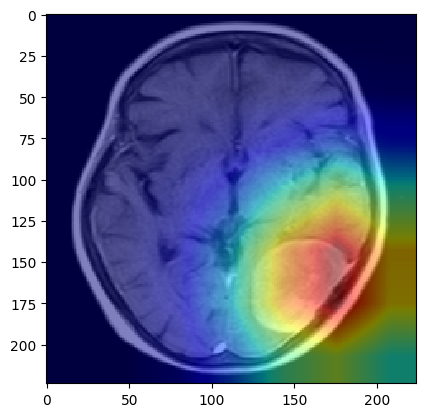

In [ ]:
import torch
import torch.nn.functional as F

def reg_hook_gradcam(last_conv_layer=None):
    # gradients for gradcam are stored here
    stored_grads = torch.Tensor([])
    stored_fpass = torch.Tensor([])

    def bpass_hook(self, gin, gout):
        global stored_grads
        stored_grads = gout

    def fpass_hook(self, ten_in, ten_out):
        global stored_fpass
        stored_fpass = ten_out

    handle_b = last_conv_layer.register_backward_hook(bpass_hook)
    handle_f = last_conv_layer.register_forward_hook(fpass_hook)

def get_gradcam(model, img, gradcampp=False, last_conv_layer=None):
    model.eval()
    reg_hook_gradcam(last_conv_layer=last_conv_layer)
    logits = model(img)
    pred = logits.argmax(dim=1).item()
    logits[:, pred].backward(retain_graph=True)
    img_hmap = np.transpose(img.squeeze().cpu().numpy(),(1,2,0))
    gradients = stored_grads[0].clone()
    activations = stored_fpass[0].clone().unsqueeze(0)
    activations = activations.detach()
    pooled_gradients = torch.mean(gradients, dim=[2, 3])
    activations *= pooled_gradients[:,:,None, None]

    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)
    return heatmap

model = models.resnet34()
model.fc = nn.Linear(model.fc.in_features, 4)
model.load_state_dict(torch.load('myweights/best_model.pth.tar'))
model.eval()
last_conv_layer = model.layer4[2].conv2
img = my_transform(img_meningioma).unsqueeze(0)
heatmap = get_gradcam(model, img, last_conv_layer=last_conv_layer)


img_np = np.array(img_meningioma)
heatmap = cv2.resize(np.array(heatmap), (img_np.shape[1], img_np.shape[0]))

plt.imshow(img_np, interpolation='nearest', cmap='gray')
plt.imshow(heatmap, interpolation='nearest', cmap=cm.jet, alpha=0.5, vmin=0, vmax=1)

DenseNet

In [ ]:
import torch
import torch.nn.functional as F

def reg_hook_gradcam(last_conv_layer=None):
    # gradients for gradcam are stored here
    stored_grads = torch.Tensor([])
    stored_fpass = torch.Tensor([])

    def bpass_hook(self, gin, gout):
        global stored_grads
        stored_grads = gout

    def fpass_hook(self, ten_in, ten_out):
        global stored_fpass
        stored_fpass = ten_out

    handle_b = last_conv_layer.register_backward_hook(bpass_hook)
    handle_f = last_conv_layer.register_forward_hook(fpass_hook)

def get_gradcam(model, img, gradcampp=False, last_conv_layer=None):
    model.eval()
    reg_hook_gradcam(last_conv_layer=last_conv_layer)
    logits = model(img)
    pred = logits.argmax(dim=1).item()
    logits[:, pred].backward(retain_graph=True)
    img_hmap = np.transpose(img.squeeze().cpu().numpy(),(1,2,0))
    gradients = stored_grads[0].clone()
    activations = stored_fpass[0].clone().unsqueeze(0)
    activations = activations.detach()
    pooled_gradients = torch.mean(gradients, dim=[2, 3])
    activations *= pooled_gradients[:,:,None, None]

    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)
    return heatmap

model = models.densenet121()
model.classifier = nn.Linear(model.classifier.in_features, 4)
model.load_state_dict(torch.load('myweights/best_model_densenet8.pth.tar'))
img = my_transform(img_meningioma).unsqueeze(0)

# Write your code

Vision Transformer

In [ ]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

def reg_hook_gradcam(last_conv_layer=None):
    # gradients for gradcam are stored here
    stored_grads = torch.Tensor([])
    stored_fpass = torch.Tensor([])

    def bpass_hook(self, gin, gout):
        global stored_grads
        stored_grads = gout

    def fpass_hook(self, ten_in, ten_out):
        global stored_fpass
        stored_fpass = ten_out

    handle_b = last_conv_layer.register_backward_hook(bpass_hook)
    handle_f = last_conv_layer.register_forward_hook(fpass_hook)

def reshape_transform(tensor, height=7, width=7):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))

    # Bring the channels to the first dimension like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

def get_gradcam(model, img, gradcampp=False, last_conv_layer=None):
    reg_hook_gradcam(last_conv_layer=last_conv_layer)
    logits = model(img)
    pred = logits.argmax(dim=1).item()
    logits[:, pred].backward(retain_graph=True)
    img_hmap = np.transpose(img.squeeze().cpu().numpy(),(1,2,0))
    gradients = stored_grads[0].clone()
    activations = stored_fpass[0].clone().unsqueeze(0)
    #Write your code to reshape and transpose the gradients and activations from [1, 50, 768] to [1, 7, 7, 768] to [1, 768, 7, 7]


    activations = activations.detach()
    pooled_gradients = torch.mean(gradients, dim=[2, 3])
    activations *= pooled_gradients[:,:,None, None]
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)
    return heatmap


model = models.vision_transformer.vit_b_32()
model.heads = nn.Linear(model.heads[0].in_features, 4)
model.load_state_dict(torch.load('myweights/best_model_vit.pth.tar'))
img = my_transform(img_meningioma).unsqueeze(0)

# Write your code
